# Validating the use of Random Forest for WW Cross-section Measurement ( 33%)

This study aims to justify feature use, forest parameters, and confirm model accuracy for data.

Outline:

- Training methodology 
- Feature use and correlations



In [1]:
run prep_ana.py

loading data frame named df.
finished loading data frame
unc_mc_process and scales are dictionaries
scale_data = (5.27/19.7)


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

In [3]:
#load root files
df_WW = rp.read_root("data/WW_tot_complete.root", "trees_vec")
df_DY = rp.read_root("data/DY_ll_complete.root", "trees_vec")
df_TT = rp.read_root("data/TT_ll_complete.root", "trees_vec")

df = pd.concat( [df_WW, df_TT, df_DY] )
df = df.reset_index()

In [4]:
train = df.sample( frac= 0.33 )
test_df = df.drop( train.index )
print train.shape, test_df.shape

(1662464, 59) (3375305, 59)


# Feature Exploration

+ Pair plots w/ features

In [6]:
features = ['nBJet', 'numb_jets', 'lep1_pt', 'lep2_pt', 'METProj', 'METProj_trk_sin', 'qT', 'mll', 'metMod', 'dPhiLLMET', 'dPhiLLJet', 'HT', 'lep_Type', 'mllMET', 'recoil' ] +\
            ['jetPt'+str(i) for i in range(1,3)] + [ 'jet'+str(i)+'_csv' for i in range(1,3) ]
#features = ['nBJet', 'numb_jets', 'lep1_pt', 'lep2_pt', 'METProj', 'qT', 'mll', 'metMod', 'dPhiLLMET', 'HT', 'lep_Type', 'numbExtraLep', 'mllMET'] +\
#            ['jetPt'+str(i) for i in range(1,7)]

In [19]:
import seaborn as sns

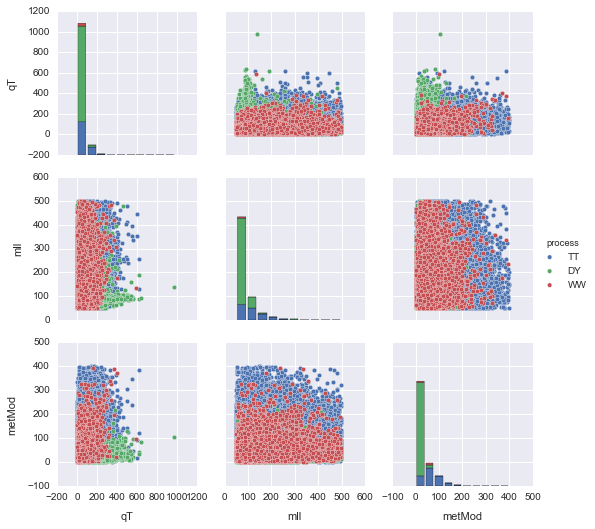

In [7]:
 sns.pairplot(train[ (train.metMod < 400) & (train.mll > 50) & (train.mll < 500) ][['qT', 'mll', 'metMod'] + ['process']], hue='process')

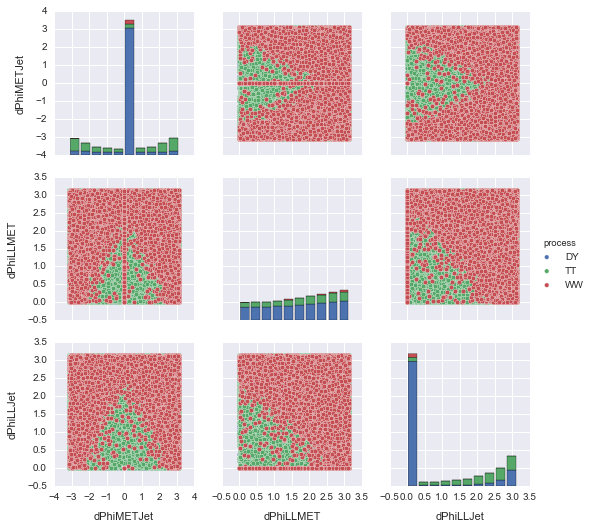

In [20]:
 sns.pairplot(train[ (train.metMod < 400) & (train.mll > 50) & (train.mll < 500) ][['dPhiMETJet', 'dPhiLLMET', 'dPhiLLJet'] + ['process']], hue='process')

In [6]:
def bin_df( df, binned_feature, scales=scales, range=None, bins=100, lumi_scale=1):
  """
  Binning stuffs:
  bin_df( df, binned_feature, range=None,bins=100, lumi_scale=1)
  """

  bins_rf = {}

  new_df = 0
  weights = None
  if "weights" in df.keys():
    weights = df.weights.values*lumi_scale
  for process in scales.keys():
      if process not in df.keys():
          new_df += 1
          continue
      bins_rf[process] = list(np.histogram(df[ (df[process]==1) ][binned_feature] , bins=bins, range=range,)) #weights=weights*scales[process]))
      bins_rf[process][0] = bins_rf[process][0] * scales[process]
      bins_rf[process].append( bins_rf[process][1][0:-1] + ( bins_rf[process][1][1:] - bins_rf[process][1][0:-1] ) / 2. )
      bins_rf[process].append( np.histogram(df[ (df[process]==1) ][binned_feature] , bins=bins, range=range, ))#weights=(weights**2)*scales[process])[0] )

  if new_df != 0:
      #print "new version"
      for process in scales.keys():
        bins_rf[process] = list(np.histogram(df[ (df["process"]==process) ][binned_feature] , bins=bins, range=range,  ))#weights=weights*scales[process]))
        bins_rf[process][0] = bins_rf[process][0] * scales[process]*lumi_scale
        bins_rf[process].append( bins_rf[process][1][0:-1] + ( bins_rf[process][1][1:] - bins_rf[process][1][0:-1] ) / 2. )
        bins_rf[process].append( np.histogram(df[ (df["process"]==process) ][binned_feature] , bins=bins, range=range, ))#weights=(weights**2)*scales[process])[0] )

  return bins_rf

# RF

In [31]:
features = ['nBJet', 'numb_jets', 'lep1_pt', 'lep2_pt', 'METProj', 'METProj_trk_sin', 'qT', 'mll', 'metMod', 'dPhiLLMET', 'dPhiLLJet', 'HT', 'lep_Type', 'mllMET', 'recoil' ] +\
            ['jetPt'+str(i) for i in range(1,3)] + [ 'jet'+str(i)+'_csv' for i in range(1,3) ]

In [32]:
#labels and weights
df_labels = np.empty( df.shape[0] )
df_weights = np.empty( df.shape[0])

df_labels[(df.process == "WW").as_matrix()] = 1
df_labels[(df.process == "DY").as_matrix()] = 2
df_labels[(df.process == "TT").as_matrix()] = 2

df_weights[(df.process == "WW").as_matrix()] = 1.
df_weights[(df.process == "DY").as_matrix()] = 1
df_weights[(df.process == "TT").as_matrix()] = 1

In [33]:
#labels and weights
labels = np.empty( train.shape[0] )
weights = np.empty( train.shape[0])

labels[(train.process == "WW").as_matrix()] = 1
labels[(train.process == "DY").as_matrix()] = 2
labels[(train.process == "TT").as_matrix()] = 2

weights[(train.process == "WW").as_matrix()] = 1.
weights[(train.process == "DY").as_matrix()] = 1
weights[(train.process == "TT").as_matrix()] = 1

In [34]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf = clf.fit( np.float32(train[features].values) , np.float32(labels), sample_weight=weights)

In [37]:
print clf.score(np.float32(train[features].values), np.float32(labels), weights)

0.98806049334


In [38]:
print clf.score(np.float32(df[features].values), np.float32(df_labels), df_weights)

0.986299689406


In [39]:
for i, f in enumerate(features):
    print f, clf.feature_importances_[i]
    

nBJet 0.011234787219
numb_jets 0.0403232963424
lep1_pt 0.0346208991453
lep2_pt 0.0258017496994
METProj 0.0474991768152
METProj_trk_sin 0.0525617558364
qT 0.0925582794638
mll 0.0813581250559
metMod 0.0482914760708
dPhiLLMET 0.0622012124944
dPhiLLJet 0.0694147936702
HT 0.0708602047315
lep_Type 0.113271673466
mllMET 0.0503972350417
recoil 0.025213688977
jetPt1 0.0794453964278
jetPt2 0.0175926702225
jet1_csv 0.0653531580574
jet2_csv 0.0120004212637


In [40]:
pred = clf.predict_proba(np.float32(test_df[features].values))

test_df["pred_WW"] = pred[:,0]
test_df["pred_DY"] = pred[:,1]
test_df["pred_TT"] = pred[:,1]

In [32]:
test_df.head()

,lep1_pt,lep2_pt,lep3_pt,numb_jets,dPhiLL,qT,HT,lep1_Charge,lep2_Charge,lep_Type,...,npv,gen_npv,runNum,lumiSec,eventNumb,weights,process,pred_WW,pred_DY,pred_TT
4,36.299286,24.709944,0,1,2.750514,16.424234,41.446785,1,-1,-1,...,26,24,1,17368,9430769,1,WW,0.259492,0.526064,0.214444
10,83.195381,34.523895,0,0,2.890264,50.491470,0.000000,-1,1,-1,...,17,15,1,17371,9432233,1,WW,0.630625,0.048573,0.320802
15,56.770088,22.825209,0,0,0.470414,77.806915,0.000000,1,-1,-1,...,26,20,1,17379,9436385,1,WW,0.196957,0.000707,0.802336
16,26.819147,24.473280,0,0,2.521740,15.802331,0.000000,-1,1,1,...,19,18,1,17379,9436440,1,WW,0.562404,0.357782,0.079814
18,107.031723,102.483391,0,0,2.734182,42.618191,0.000000,-1,1,-1,...,45,33,1,17379,9436517,1,WW,0.639816,0.133842,0.226342


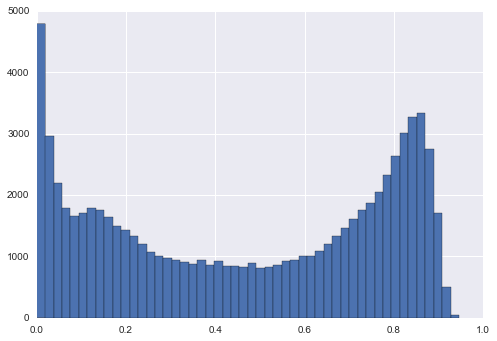

In [42]:
test_df[ (test_df.process == "WW") ].pred_WW.hist( bins= 50 )

# process

In [46]:
cut = 0.659
feature_cuts =  (test_df.pred_WW > cut) & (test_df.numbExtraLep == 0) #& (test_df.qT > 0) & ()
feature_cuts_diff =( test_df.lep_Type > 0 ) & feature_cuts
feature_cuts_same = (test_df.lep_Type < 0) & feature_cuts
for process in scales.keys():
    if process in test_df.process.unique():
        print process, test_df[ (test_df.process == process) & feature_cuts_diff].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test_df[test_df.process == process].shape[0]),\
    test_df[ (test_df.process == process) & feature_cuts_same].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test_df[test_df.process == process].shape[0])

WW 3959.14456388 1298.88805874
DY 1203.63360669 698.994020882
TT 244.317583109 84.5131660289


(51120, 58)

In [ ]:
(45440, 58)